<a href="https://colab.research.google.com/github/evcu/micrograd/blob/sparse/sparse-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sparse Networks with MicroGrad
O lala, time passes fast under quarantine. It has been almost 3 weeks since Andrej Karparty shared his super light-weight autograd library and me getting exciting about it. Roughly 2 years ago I had a similar mini-project and wrote about it [here](https://evcu.github.io/ml/autograd/). After seeing Micrograd and its simplicity I decided to spend some time on it. 

Andrej's implementation works on pure python and the speed is not a concern. I thought maybe we can accelerate it using sparsity :P. Just kidding...

I realized how easy it would be to implement sparse networks if the building blocks are neurons. It litteraly took me few hours to implement sparse networks and **RigL** algorithm. I think this is a great demonstration of the power of changing abstractions. The abstractions and tools we have influences our work/research greatly and maybe what we need is a paradigm shift to enable the next big jump in AI. I would vote for neurons as the future building blocks of Neural Networks. But arguing about this is not the goal of this notebook.

### Plan
- Checkout Andrej's implementation of `Value` [here](https://github.com/evcu/micrograd/blob/sparse/micrograd/engine.py). This is the building block of the learning algorithm and it is the simplest autograd engine I've seen.
- Checkout the [demo](https://github.com/evcu/micrograd/blob/sparse/demo.ipynb). At the end of this notebook, we would do the same experiment using sparse networks. 
- We implement Sparse network (SparseMLP) which uses the SparseLayer which uses the SparseNeuron. 
- Finally we will train our network on a binary classification task. We will observe the failure of regular sparse training and we see how RigL can be used to improve performance considerably.


Cloning into 'g_micrograd'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 156 (delta 81), reused 118 (delta 47), pack-reused 0
Receiving objects: 100% (156/156), 346.16 KiB | 639.00 KiB/s, done.
Resolving deltas: 100% (81/81), done.


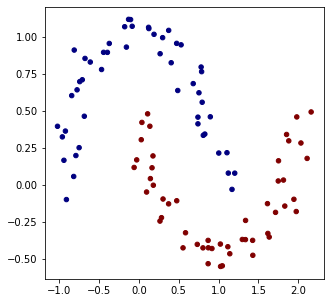

In [2]:
#@title Imports, Helpers and Data Load
from functools import partial
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
%matplotlib inline
!rm -rf g_micrograd micrograd
!git clone --single-branch --branch sparse https://github.com/evcu/micrograd.git g_micrograd
!mv g_micrograd/micrograd ./
from micrograd.engine import Value
from micrograd.nn import Module
from micrograd.rigl import Module
# make up a dataset
from graphviz import Digraph

def draw_topology(model, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    with dot.subgraph(name=f'cluster_inp') as c:
      c.node(name='0_1', label = '0_1' , shape='record')
      c.node(name='0_0', label = '0_0' , shape='record')
    for i, layer in enumerate(model.layers):
      for j, neuron in enumerate(layer.neurons):
        with dot.subgraph(name=f'cluster_{i}') as c:
          c_node = f'{i+1}_{j}'
          c.node(name=c_node, label = c_node , shape='record')
          for incoming_neuron_id in neuron.w.keys():
            from_node = f'{i}_{incoming_neuron_id}'
            c.edge(from_node, c_node)
    
    return dot

X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### Defining Sparse Network
Neurons in a layer usually connects to the every neuron in the previous layer. This is because how we define them. We call such networks **dense** (although I would argue they are sparse, too since they are not connecting bunch of other neurons in other layers.). 

On the other hand sparse networks connect to only a fraction of the neurons in the previous layers and the sparsity of a neuron can be defined as the fraction of neurons it *doesn't* connect. So number of connections in a sparse neuron would be defined by,

$$\#connections = \lfloor(1 - sparsity) * \#input\_neurons\rfloor$$

Below, we share the implementation of `SparseNeuron`. It calculates number of connections as defined above and holds the weights in a dictionary `self.w` using the index of the input neurons as keys.

RigL algorithm, sometimes need to calculate the gradient of the non-existing connections. In order to do that we define `self.zero_ws` which are populated if the `dense_grad=True`. 

In [0]:
class SparseNeuron(Module):

    def __init__(self, nin, sparsity, nonlin=True):
        assert 0 <= sparsity < 1
        n_weights = math.ceil((1 - sparsity) * nin)
        w_indices = random.sample(range(n_weights), k=n_weights)
        self.w = {i: Value(random.uniform(-0.1, 0.1)) for i in w_indices}
        self.b = Value(0)
        self.nonlin = nonlin
        self.zero_ws = {}

    def __call__(self, x, dense_grad=False):
        if dense_grad:
            # We need to calculate all gradients therefore introduce zeros.
            self.zero_ws = {}
            results = []
            for i, xi in enumerate(x):
                if i in self.w:
                    results.append(self.w[i]*xi)
                else:
                    self.zero_ws[i] = Value(0)
                    results.append(self.zero_ws[i]*xi)

            act = sum(results, self.b)
            return act.relu() if self.nonlin else act
        else:
            act = sum((wi*x[i] for i, wi in self.w.items()), self.b)
            return act.relu() if self.nonlin else act        
    
    def parameters(self):
        return list(self.w.values()) + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

### Defining Larger Building Blocks and Loss
Next we define `SparseLayer`, `SparseMLP` and the `loss` function. Nothing special here expect the regular neurons are replaced by sparse neurons. `SparseMLP` expects the list of sparsities in addition to the hidden layer sizes.

In [0]:
#@title SparseLayer, SparseML implementation and the loss
class SparseLayer(Module):

    def __init__(self, nin, nout, sparsity=0, **kwargs):
        self.neurons = [SparseNeuron(nin, sparsity, **kwargs) for _ in range(nout)]

    def __call__(self, x, dense_grad=False):
        out = [n(x, dense_grad=dense_grad) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class SparseMLP(Module):

    def __init__(self, nin, nouts, sparsities):
        sz = [nin] + nouts
        self.layers = [SparseLayer(sz[i], sz[i+1], sparsity=sparsities[i],
                                   nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x, dense_grad=False):
        for layer in self.layers:
            x = layer(x, dense_grad=dense_grad)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        main_str = '\n'.join(str(layer) for layer in self.layers)
        return f"MLP of [\n{main_str}\n]"

# loss function
def loss(model, batch_size=None, dense_grad=False):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(partial(model, dense_grad=dense_grad), inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

# Our Sparse Network
Here we create a sparse network. Note that there is only 2 input dimensions and we would like first set of neurons (input layer) to use both of the input dimensions. Therefore we set the sparsity to 0 for the first layer. Last layer also has a single output neuron, therefore we set its sparsity to a lower value than the middle layer. 

These sparsities are selected arbitrarily, feel free to play with them.

Let's create this model and train it.

In [18]:
np.random.seed(1337)
random.seed(1337)
model = SparseMLP(nin=2, nouts=[16, 16, 1], sparsities=[0.,0.9,0.8]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [
Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
Layer of [LinearNeuron(4)]
]
number of parameters 101


In [19]:
# initialize a model 
TRAIN_STEPS = 400
for k in range(TRAIN_STEPS):
    
    # forward
    total_loss, acc = loss(model)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1 - 0.9*k/TRAIN_STEPS
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 20 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.9999118995994747, accuracy 50.0%
step 20 loss 0.9501034046836242, accuracy 50.0%
step 40 loss 0.3029776283757717, accuracy 87.0%
step 60 loss 0.297169433748757, accuracy 87.0%
step 80 loss 0.29289542954897096, accuracy 88.0%
step 100 loss 0.2931921490672611, accuracy 87.0%
step 120 loss 0.2989848931028507, accuracy 88.0%
step 140 loss 0.29119501442717843, accuracy 87.0%
step 160 loss 0.29066315530929504, accuracy 88.0%
step 180 loss 0.2899413473514983, accuracy 88.0%
step 200 loss 0.29011181298721417, accuracy 88.0%
step 220 loss 0.2897383548597768, accuracy 88.0%
step 240 loss 0.28930190046206183, accuracy 88.0%
step 260 loss 0.2886158754721535, accuracy 87.0%
step 280 loss 0.2881950427716646, accuracy 88.0%
step 300 loss 0.28796501931513896, accuracy 87.0%
step 320 loss 0.28737672236751133, accuracy 88.0%
step 340 loss 0.2875214701885475, accuracy 88.0%
step 360 loss 0.2868703953378429, accuracy 88.0%
step 380 loss 0.2867664506170351, accuracy 88.0%
step 399 loss 0.2865

# Difficulty of Training Sparse Networks.
Sparse training is difficult. This has been by many, but probably popularized by the [Lottery Ticket Hypothesis](https://arxiv.org/abs/1803.03635) work of Jonathan. [RigL](https://arxiv.org/abs/1911.11134) is one of the recent dynamic training algoritms along with the others ([SNFS](https://arxiv.org/abs/1907.04840), [SET](https://www.nature.com/articles/s41467-018-04316-3), [DSR](https://arxiv.org/abs/1902.05967)). RigL improves the training of sparse networks by changing how the neurons are wired during the training.

RigL takes the model as input and updates its connections and give better results than static training:

1) Calculate dense gradient, which enables us to obtain the gradient of non-existing connectons using `SparseNeuron.zero_ws`.

2) For each layer obtain existing and candidate parameters. 

3) If no parameters to update, skip continue with the next layer.

4) Obtain candidate connections with highest gradient magnitude.

5) Obtain existing connections with lowest magnitude.

6) Replace least magnitude connections with new ones that have high expected gradient.

In [0]:
from micrograd.rigl import top_k_param_dict     
            
def rigl_update_layer(model, update_fraction=0.3):
    # (1) Calculating dense gradient
    total_loss, acc = loss(model, dense_grad=True)
    model.zero_grad()
    total_loss.backward()
    
    for layer in model.layers:
        n_weights = 0
        # (2) For each layer obtain existing and candidate parameters.
        candidate_params, params = [], []
        for j, neuron in enumerate(layer.neurons):
            n_weights += len(neuron.w)
            # Decide connections to grow (pick top gradient magnitude).
            candidate_params.extend([(p, i, j)  for i, p in neuron.zero_ws.items()])
            params.extend([(p, i, j)  for i, p in neuron.w.items()])
            # Done with zero_ws delete them.
            neuron.zero_ws = {}       

        # (3) If no parameters to update, skip this layer
        n_update = math.floor(n_weights * update_fraction)
        if n_update == 0:
            # Not updating
            continue

        # (4) Obtain candidate connections with highest gradient magnitude.
        top_grad_fn = lambda p: abs(p.grad)
        top_k_candidate_params = top_k_param_dict(candidate_params, n_update, sort_fn=top_grad_fn)
        # (5) Obtain existing connections with lowest magnitude.
        least_magnutide_fn = lambda p: -abs(p.data)
        bottom_k_params = top_k_param_dict(params, n_update, sort_fn=least_magnutide_fn)
        # (6) Replace least magnitude connections with new ones with high expected gradient.
        for (p, i, j), (_, i_new, j_new) in zip(bottom_k_params, top_k_candidate_params):
            del layer.neurons[j].w[i]
            p.data = 0.
            layer.neurons[j_new].w[i_new] = p

In [20]:
np.random.seed(1337)
random.seed(1337)
model = SparseMLP(2, [16, 16, 1], [0.,0.9,0.8]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [
Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
Layer of [LinearNeuron(4)]
]
number of parameters 101


In [21]:
N_TOTAL = 400
for k in range(N_TOTAL):    
    # forward
    total_loss, acc = loss(model)
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1 - 0.9*k/N_TOTAL
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    if k % 20 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
        if k != 0: rigl_update_layer(model, update_fraction=learning_rate*0.3)

step 0 loss 0.9999118995994747, accuracy 50.0%
step 20 loss 0.9501034046836242, accuracy 50.0%
step 40 loss 0.3100530789154368, accuracy 86.0%
step 60 loss 0.2943928150384549, accuracy 87.0%
step 80 loss 0.29081179132781054, accuracy 88.0%
step 100 loss 0.28761794723703316, accuracy 88.0%
step 120 loss 0.2844175041217566, accuracy 86.0%
step 140 loss 0.3083420441792059, accuracy 85.0%
step 160 loss 0.27962001315071733, accuracy 88.0%
step 180 loss 0.2701977359724511, accuracy 89.0%
step 200 loss 0.2548698443690212, accuracy 90.0%
step 220 loss 0.25193384339378755, accuracy 90.0%
step 240 loss 0.14442011238413374, accuracy 96.0%
step 260 loss 0.22868415294455952, accuracy 96.0%
step 280 loss 0.06459693547356632, accuracy 97.0%
step 300 loss 0.06183151633336271, accuracy 100.0%
step 320 loss 0.04567886755653706, accuracy 99.0%
step 340 loss 0.041562365614153496, accuracy 100.0%
step 360 loss 0.03462738757482676, accuracy 100.0%
step 380 loss 0.03115376154018684, accuracy 100.0%


## Results
RigL obtains 0.003 loss with 100% acc vs static training stucks  at 0.287 with 88% acc. Visualizing the connectivity of the model after the RigL training reveals interesting insights. We see that the available connections are used by few important neurons and many neurons internal neurons are discarded.

For example below neurons `2_3` and `2_1` has the most of the connections of the second layer. Other active neurons (`2_4` and `2_2`) has only 1 incoming connections. All the remaining neurons are dead, which means they don't have any incoming or outgoing connections, therefore they can't effect the output. We can safely remove such dead units. Let's do that.


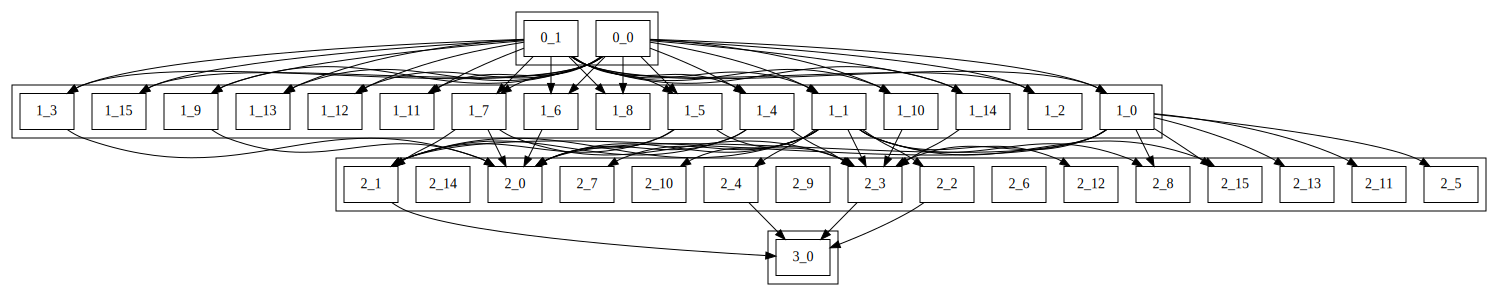

In [22]:
draw_topology(model, rankdir='TB')

### Stripping Dead Units
Removing dead units we are left with a compact 10,4,1 (compared to 16,16,1) architecture.

MLP of [
Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)]
Layer of [ReLUNeuron(5), ReLUNeuron(1), ReLUNeuron(7), ReLUNeuron(1)]
Layer of [LinearNeuron(4)]
]


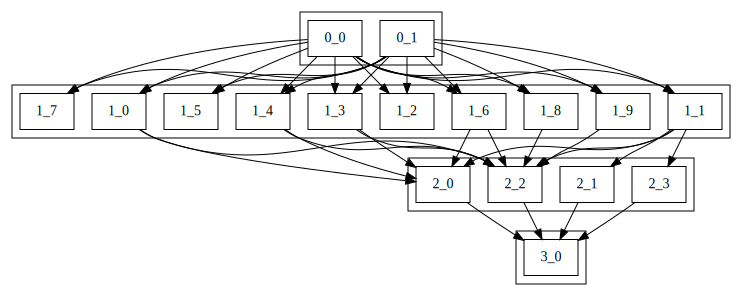

In [24]:
from micrograd.rigl import strip_deadneurons     
new_model = strip_deadneurons(model)
print(new_model)
draw_topology(new_model, rankdir='TB')

# Visualizing the decision boundries
Let's (yet again) use Andrej's code to visualize the decision boundries.

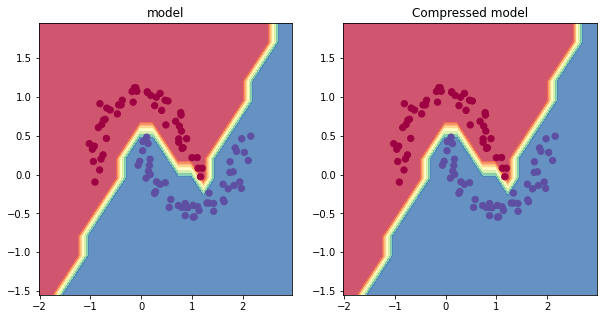

In [30]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
Zs = []
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
for m in [model, new_model]:
  scores = list(map(m, inputs))
  Z = np.array([s.data > 0 for s in scores])
  Zs.append(Z.reshape(xx.shape))

fig, axs = plt.subplots(1, 2, figsize=(10,5))
for i, key in enumerate(['model', 'Compressed model']):
  plt.axes(axs[i])
  plt.contourf(xx, yy, Zs[i], cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
  plt.title(key)


### Acknowledgements
Most of this notebook is based on Andrej Karpathy's original demo at [micrograd](https://github.com/karpathy/micrograd) repo. So I would like to thank Andrej for open-sourcing and sharing his code. 